In [1]:
import numpy as np
import pandas as pd
import missingno as msno
%matplotlib inline

### Importing datasets

In [2]:
properties_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/properties_2016.csv'
train_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/train_2016_v2.csv'

properties = pd.read_csv(filepath_or_buffer=properties_path)
train = pd.read_csv(filepath_or_buffer=train_path)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
properties.set_index('parcelid', inplace=True)
properties['latitude'] = properties['latitude'] / 1e6
properties['longitude'] = properties['longitude'] / 1e6

In [4]:
properties_in_train = properties.loc[train['parcelid'].drop_duplicates()]

In [5]:
print(properties.shape)
print(train.shape)
print(properties_in_train.shape)

(2985217, 57)
(90275, 3)
(90150, 57)


### Visualization of Missing Values

In [6]:
# missing percentage
properties_in_train.count().sort_values() / properties_in_train.shape[0]

buildingclasstypeid             0.000177
finishedsquarefeet13            0.000366
basementsqft                    0.000477
storytypeid                     0.000477
yardbuildingsqft26              0.001054
fireplaceflag                   0.002440
architecturalstyletypeid        0.002884
typeconstructiontypeid          0.003306
finishedsquarefeet6             0.004648
decktypeid                      0.007299
poolsizesum                     0.010715
pooltypeid10                    0.012856
pooltypeid2                     0.013356
taxdelinquencyflag              0.019689
taxdelinquencyyear              0.019689
hashottuborspa                  0.026212
yardbuildingsqft17              0.029340
finishedsquarefeet15            0.039434
finishedfloor1squarefeet        0.075984
finishedsquarefeet50            0.075984
fireplacecnt                    0.106456
threequarterbathnbr             0.133067
pooltypeid7                     0.184936
poolcnt                         0.198292
numberofstories 

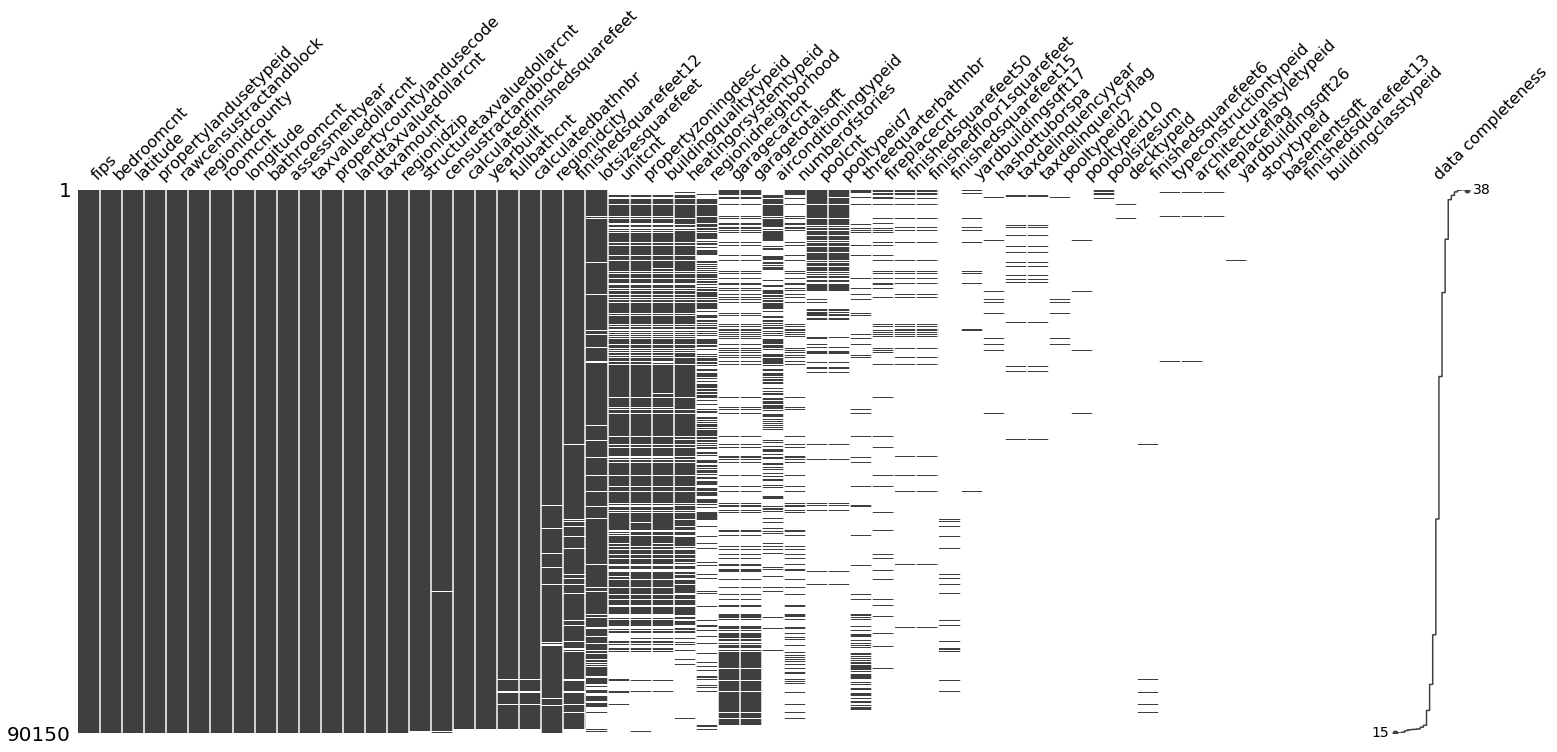

In [8]:
colnames = properties_in_train.count().sort_values(ascending=False).index
msno.matrix(msno.nullity_sort(properties_in_train[colnames], sort='descending'), 
            labels=True)

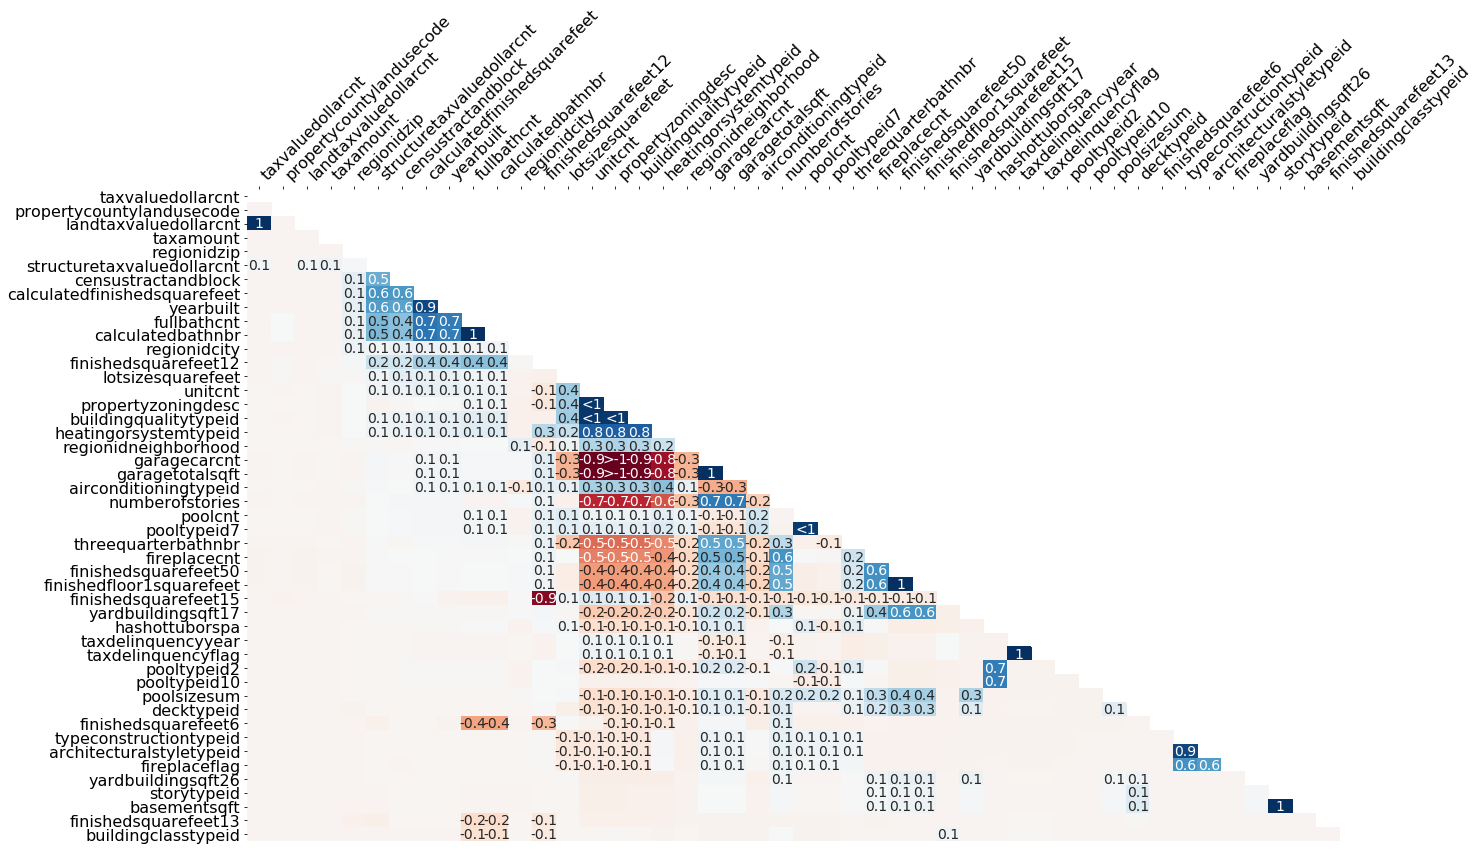

In [9]:
msno.heatmap(properties_in_train[colnames])

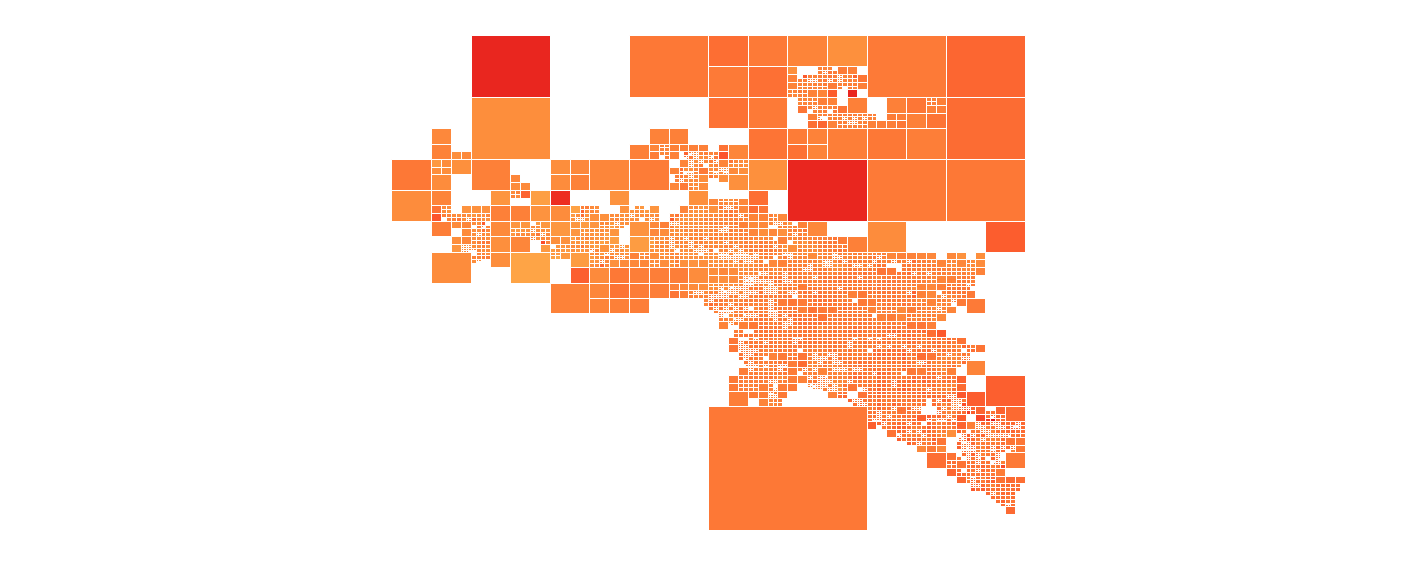

In [10]:
msno.geoplot(properties_in_train, 
             x='longitude', 
             y='latitude')

### Preprocessing data

In [11]:
def preprocessing(data, *args):
    for func in args:
        print('preprocessing step: {}'.format(func.__name__))
        data = func(data)
    return data

In [12]:
# buildingclasstypeid: The building framing type (steel frame, wood frame, concrete/brick) 
print(properties['buildingclasstypeid'].value_counts(dropna=False))
print(properties_in_train['buildingclasstypeid'].value_counts(dropna=False))

NaN     2972588
 4.0       9265
 3.0       3161
 2.0         81
 1.0         65
 5.0         57
Name: buildingclasstypeid, dtype: int64
NaN     90134
 4.0       16
Name: buildingclasstypeid, dtype: int64


In [13]:
def preproc_buildingclasstypeid(data):
    col = 'buildingclasstypeid'
    data.loc[data[col] != 4, col] = 0
    data.loc[data[col] == 4, col] = 1
    data.loc[:, col].fillna(0, inplace=True)
    return data

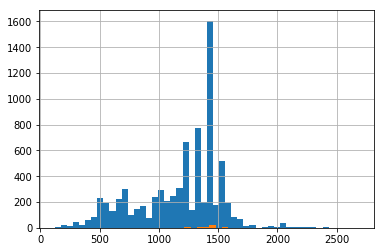

In [14]:
# finishedsquarefeet13: Perimeter living area
properties['finishedsquarefeet13'].hist(bins=50)
properties_in_train['finishedsquarefeet13'].hist()

In [15]:
def preproc_finishedsquarefeet13(data):
    col = 'finishedsquarefeet13'
    data.loc[:, col].fillna(0, inplace=True)
    return data

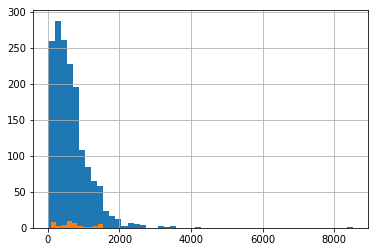

In [16]:
# basementsqft: Finished living area below or partially below ground level
properties['basementsqft'].hist(bins=50)
properties_in_train['basementsqft'].hist()

In [17]:
# storytypeid: Type of floors in a multi-story house
print(properties['storytypeid'].value_counts(dropna=False))
print(properties_in_train['storytypeid'].value_counts(dropna=False))

NaN     2983593
 7.0       1624
Name: storytypeid, dtype: int64
NaN     90107
 7.0       43
Name: storytypeid, dtype: int64


In [18]:
def preproc_storytypeid(data):
    data = data.drop('storytypeid', axis=1)
    return data

def preproc_basementsqft(data):
    data.loc[:, 'basementsqft'].fillna(0, inplace=True)
    return data

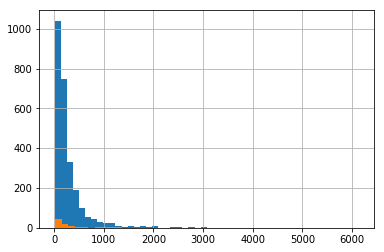

In [19]:
# yardbuildingsqft26: Storage shed/building in yard
properties['yardbuildingsqft26'].hist(bins=50)
properties_in_train['yardbuildingsqft26'].hist()

In [20]:
def preproc_yardbuildingsqft26(data):
    data.loc[:, 'yardbuildingsqft26'].fillna(0, inplace=True)
    return data

In [21]:
# regionidcounty & fips
pd.pivot_table(properties, 
               values='latitude',
               index=['fips'],
               columns=['regionidcounty'], 
               aggfunc=len)

regionidcounty,1286.0,2061.0,3101.0
fips,,,
6037.0,NaN,NaN,2009362.0
6059.0,741565.0,NaN,NaN
6111.0,NaN,222853.0,NaN


In [22]:
pd.pivot_table(properties_in_train, 
               values='latitude',
               index=['fips'],
               columns=['regionidcounty'], 
               aggfunc=len)

regionidcounty,1286.0,2061.0,3101.0
fips,,,
6037.0,NaN,NaN,58493.0
6059.0,24467.0,NaN,NaN
6111.0,NaN,7190.0,NaN


In [23]:
def preproc_regionidcounty(data):
    col = 'regionidcounty'
    data.loc[data[col] == 3101.0, col] = 1
    data.loc[data[col] == 1286.0, col] = 2
    data.loc[data[col] == 2061.0, col] = 3
    data.loc[:, col].fillna(0, inplace=True)
    return data

def preproc_fips(data):
    data = data.drop('fips', axis=1)
    return data

In [24]:
# fireplaceflag:Is a fireplace present in this home 
properties['fireplaceflag'].value_counts(dropna=False)

NaN     2980054
True       5163
Name: fireplaceflag, dtype: int64

In [25]:
def preproc_fireplaceflag(data):
    col = 'fireplaceflag'
    data.loc[data[col] == True, col] == 1
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [26]:
# architecturalstyletypeid: Architectural style of the home
print(properties['architecturalstyletypeid'].value_counts(dropna=False))
print(properties_in_train['architecturalstyletypeid'].value_counts(dropna=False))

NaN      2979156
 7.0        5251
 8.0         380
 2.0         201
 21.0        150
 3.0          58
 5.0          19
 27.0          1
 10.0          1
Name: architecturalstyletypeid, dtype: int64
NaN      89890
 7.0       220
 8.0        16
 2.0        11
 21.0        8
 3.0         4
 10.0        1
Name: architecturalstyletypeid, dtype: int64


In [27]:
def preproc_architecturalstyletypeid(data):
    col = 'architecturalstyletypeid'
    levels = [2.0,3.0,7.0,8.0,10.0,21.0]
    data.loc[~data[col].isin(levels), col] = 0
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [28]:
# typeconstructiontypeid: What type of construction material was used to construct the home
print(properties['typeconstructiontypeid'].value_counts(dropna=False))
print(properties_in_train['typeconstructiontypeid'].value_counts(dropna=False))

NaN      2978470
 6.0        6670
 4.0          59
 13.0         14
 10.0          3
 11.0          1
Name: typeconstructiontypeid, dtype: int64
NaN      89852
 6.0       295
 4.0         2
 13.0        1
Name: typeconstructiontypeid, dtype: int64


In [29]:
def preproc_typeconstructiontypeid(data):
    col = 'typeconstructiontypeid'
    levels = [4.0, 6.0, 13.0]
    data.loc[~data[col].isin(levels), col] = 0
    data.loc[:, col].fillna(0, inplace=True)
    return data

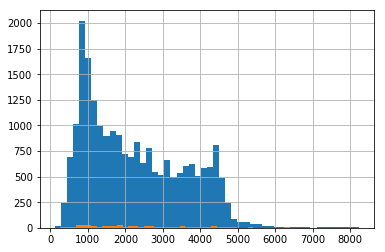

In [30]:
# finishedsquarefeet6: Base unfinished and finished area
properties.loc[properties['finishedsquarefeet6'] < properties['finishedsquarefeet6'].quantile(0.995), 
               'finishedsquarefeet6'].hist(bins=50)
properties_in_train['finishedsquarefeet6'].hist(bins=50)

In [31]:
def preproc_finishedsquarefeet6(data):
    data.loc[:, 'finishedsquarefeet6'].fillna(0, inplace=True)
    return data

In [32]:
# decktypeid: Type of deck (if any) present on parcel
print(properties['decktypeid'].value_counts(dropna=False))
print(properties_in_train['decktypeid'].value_counts(dropna=False))

NaN      2968121
 66.0      17096
Name: decktypeid, dtype: int64
NaN      89492
 66.0      658
Name: decktypeid, dtype: int64


In [33]:
def preproc_decktypeid(data):
    col = 'decktypeid'
    data.loc[data[col] == 2061.0, col] = 3
    data.loc[:, col].fillna(0, inplace=True)
    return data

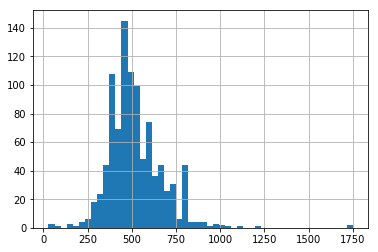

In [34]:
# poolsizesum: Total square footage of all pools on property
properties_in_train['poolsizesum'].hist(bins=50)

In [35]:
# pooltypeid10
print(properties['pooltypeid10'].value_counts(dropna=False))
print(properties['pooltypeid2'].value_counts(dropna=False))
print(properties['pooltypeid7'].value_counts(dropna=False))
print(properties['poolcnt'].value_counts(dropna=False))

NaN     2948278
 1.0      36939
Name: pooltypeid10, dtype: int64
NaN     2953142
 1.0      32075
Name: pooltypeid2, dtype: int64
NaN     2499758
 1.0     485459
Name: pooltypeid7, dtype: int64
NaN     2467683
 1.0     517534
Name: poolcnt, dtype: int64


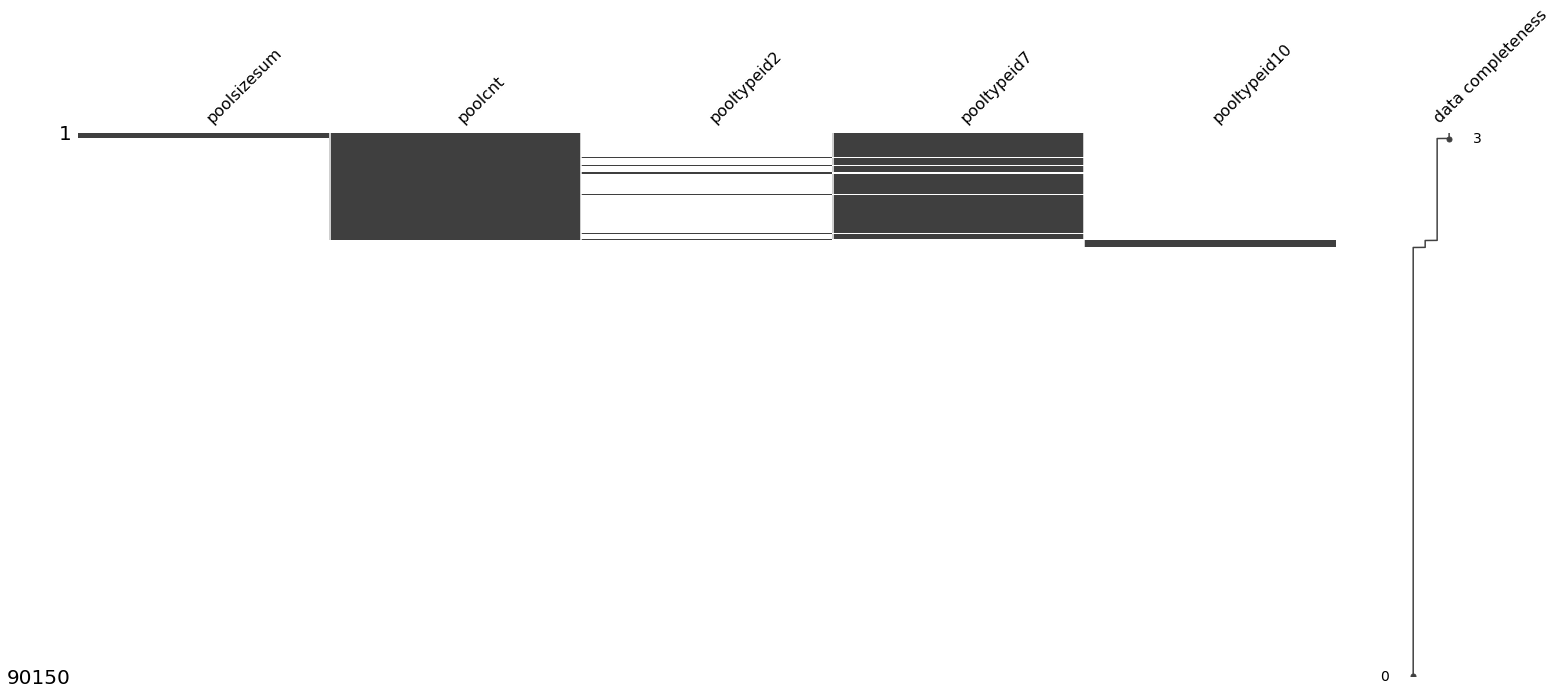

In [36]:
msno.matrix(msno.nullity_sort(properties_in_train[['poolsizesum','poolcnt','pooltypeid2','pooltypeid7','pooltypeid10']], 
                              sort='descending'), 
            labels=True)

In [37]:
def preproc_pooltype(data):
    data.loc[:, 'poolcnt'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid2'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid7'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid10'].fillna(0, inplace=True)
    data['pooltype'] = data['pooltypeid10'] + data['pooltypeid7']*2 + data['pooltypeid2']*3
    data = data.drop('pooltypeid2', axis=1).drop('pooltypeid7', axis=1).drop('pooltypeid10', axis=1)
    return data

In [38]:
# taxdelinquencyflag
print(properties['taxdelinquencyflag'].value_counts(dropna=False))

NaN    2928755
Y        56462
Name: taxdelinquencyflag, dtype: int64


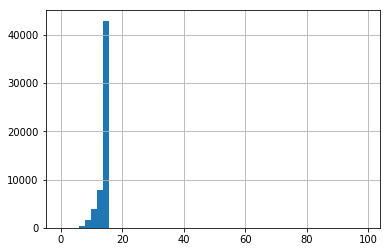

In [39]:
properties['taxdelinquencyyear'].hist(bins=50)

In [40]:
def preproc_taxdelinquencyflag(data):
    col = 'taxdelinquencyflag'
    data.loc[:, col].fillna(0, inplace=True)
    data.loc[data[col] == 'Y', col] = 1
    return data

def preproc_taxdelinquencyyear(data):
    col = 'taxdelinquencyyear'
    data.loc[data[col] < 20.0, col] = data.loc[data[col] < 2.0, col] + 2000
    data.loc[data[col] < 100.0, col] = data.loc[data[col] < 100.0, col] + 1900
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [41]:
properties_in_train = preprocessing(
    properties_in_train, 
    preproc_buildingclasstypeid,
    preproc_finishedsquarefeet13,
    preproc_basementsqft,
    preproc_storytypeid,
    preproc_yardbuildingsqft26,
    preproc_regionidcounty,
    preproc_fips,
    preproc_fireplaceflag,
    preproc_architecturalstyletypeid,
    preproc_typeconstructiontypeid,
    preproc_finishedsquarefeet6,
    preproc_decktypeid,
    preproc_pooltype,
    preproc_taxdelinquencyflag,
    preproc_taxdelinquencyyear,
)

preprocessing step: preproc_buildingclasstypeid
preprocessing step: preproc_finishedsquarefeet13
preprocessing step: preproc_basementsqft
preprocessing step: preproc_storytypeid
preprocessing step: preproc_yardbuildingsqft26
preprocessing step: preproc_regionidcounty
preprocessing step: preproc_fips
preprocessing step: preproc_fireplaceflag
preprocessing step: preproc_architecturalstyletypeid
preprocessing step: preproc_typeconstructiontypeid
preprocessing step: preproc_finishedsquarefeet6
preprocessing step: preproc_decktypeid
preprocessing step: preproc_pooltype
preprocessing step: preproc_taxdelinquencyflag
preprocessing step: preproc_taxdelinquencyyear


In [42]:
properties = preprocessing(
    properties, 
    preproc_buildingclasstypeid,
    preproc_finishedsquarefeet13,
    preproc_basementsqft,
    preproc_storytypeid,
    preproc_yardbuildingsqft26,
    preproc_regionidcounty,
    preproc_fips,
    preproc_fireplaceflag,
    preproc_architecturalstyletypeid,
    preproc_typeconstructiontypeid,
    preproc_finishedsquarefeet6,
    preproc_decktypeid,
    preproc_pooltype,
    preproc_taxdelinquencyflag,
    preproc_taxdelinquencyyear,
)

preprocessing step: preproc_buildingclasstypeid
preprocessing step: preproc_finishedsquarefeet13
preprocessing step: preproc_basementsqft
preprocessing step: preproc_storytypeid
preprocessing step: preproc_yardbuildingsqft26
preprocessing step: preproc_regionidcounty
preprocessing step: preproc_fips
preprocessing step: preproc_fireplaceflag
preprocessing step: preproc_architecturalstyletypeid
preprocessing step: preproc_typeconstructiontypeid
preprocessing step: preproc_finishedsquarefeet6
preprocessing step: preproc_decktypeid
preprocessing step: preproc_pooltype
preprocessing step: preproc_taxdelinquencyflag
preprocessing step: preproc_taxdelinquencyyear


### Data Preparation

In [83]:
train_set = pd.merge(
    properties_in_train.dropna(axis=1), 
    train, 
    left_index = True, 
    right_on='parcelid'
)
train_set['month'] = pd.to_datetime(train_set['transactiondate']).dt.month
train_set = train_set.drop('parcelid', axis=1).drop('transactiondate', axis=1).drop('assessmentyear', axis=1)

In [84]:
X = train_set.drop('logerror', axis=1)
y = train_set['logerror']

In [86]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=2, 
                               criterion='mae',
                               random_state=0, 
                               verbose=1)
rf_reg.fit(X, y)

KeyboardInterrupt: 

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

In [53]:
properties_in_train.count() == properties_in_train.shape[0]

airconditioningtypeid           False
architecturalstyletypeid         True
basementsqft                     True
bathroomcnt                      True
bedroomcnt                       True
buildingclasstypeid              True
buildingqualitytypeid           False
calculatedbathnbr               False
decktypeid                       True
finishedfloor1squarefeet        False
calculatedfinishedsquarefeet    False
finishedsquarefeet12            False
finishedsquarefeet13             True
finishedsquarefeet15            False
finishedsquarefeet50            False
finishedsquarefeet6              True
fireplacecnt                    False
fullbathcnt                     False
garagecarcnt                    False
garagetotalsqft                 False
hashottuborspa                  False
heatingorsystemtypeid           False
latitude                         True
longitude                        True
lotsizesquarefeet               False
poolcnt                          True
poolsizesum 

In [ ]:
def hist_density_plot(data, x, quantile=None, logx=False, bins=50):
    if not quantile is None:
        data = data.query('{1} < {0} < {2}'.format(x, *train['logerror'].quantile([.01, .99])))
    data = data[x]
    if logx:
        data = np.log(data + 1)
    data.plot(kind='hist', xlim=(min(data), max(data)), bins=bins, color='blue', alpha=.5)
    data.plot(kind='kde', xlim=(min(data), max(data)), secondary_y=True, color='black')

In [ ]:
hist_density_plot(train, quantile=[.01, .99], x='logerror')

In [ ]:
train['logerror'].quantile([.01, .99])

In [ ]:
'{1} < {0} < {2}'.format('abc', *train['logerror'].quantile([.01, .99]))

In [ ]:
properties[colnames].describe()

In [ ]:
print(properties_sample.loc[:, 'fips'].value_counts(dropna=False))
print(properties_sample.loc[:, 'regionidcounty'].value_counts(dropna=False))

In [ ]:
import numpy as np

pd.pivot_table(properties, 
               values='parcelid',
               index=['fips'],
               columns=['regionidcounty'], 
               aggfunc=len)

In [ ]:
catetorical = [
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'fireplaceflag',
    'hashottuborspa',
    'heatingorsystemtypeid',
    'numberofstories',
    'parcelid',
    'poolsizesum'
'pooltypeid10'
'pooltypeid2'
'pooltypeid7'
'propertycountylandusecode'
'propertylandusetypeid'
'propertyzoningdesc'
'rawcensustractandblock'
'censustractandblock'
'regionidcounty'
'regionidcity'
'regionidzip'
'regionidneighborhood'
'roomcnt'
'storytypeid'
'typeconstructiontypeid'
'unitcnt'
'yardbuildingsqft17'
'yardbuildingsqft26'
'yearbuilt'
'taxvaluedollarcnt'
'structuretaxvaluedollarcnt'
'landtaxvaluedollarcnt'
'taxamount'
'assessmentyear'
'taxdelinquencyflag'
'taxdelinquencyyear']
for col in catetorical:
    properties[col] = properties[col].astype('category')

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X = [[0, 2, 0, 3], [0, 1, 4, 3], ['a', 1, 1, 3]]

selector = VarianceThreshold(threshold=0.0)
selector.fit_transform(properties)